In [1]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 26. 01. 2024      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Creating JRA55-do-1-5-0 sea surface temperature anomalies

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-5-0'                                                                                              #
period = ['1958','2019','2021','2023'] # which period to consider for anomaly calculation    #
version = ['v20200916', 'v20210315', 'latest'] #'v20190429'                                                    #
# ------------------------------------------------------------------------------------------------------------ #
base  = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
base2 = '/g/data/ik11/inputs/JRA-55/JRA55-do-' + forcing + '-1/mirror/'
out   = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var   = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables except the two wind stress components
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; short = 'gr'
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']; short = 'gr'
    if var[i] in ['tos']:                               domain = 'ocean/day/';   timestep = ['0101','1231']; short = 'gn'
    if var[i] in ['friver']:                            domain = 'land/day/';   timestep = ['0101','1231']; short = 'gr'
    print(domain+var[i])

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[3]+'.nc'
    if os.path.isfile(f2) == True: # skip iteration if final .nc file already exists
        continue               

# Step I: merge 01-Jan-1958 to 31-Dec-2019 files and create monthly mean fields
    cdo.monmean(input = '-mergetime ' + base + domain + var[i] + '/'+short+'/'+version[0]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
# Step II: the first extension for 01-Jan-2020 to 31-Dec-2020
    cdo.monmean(input = base2 + domain + var[i] + '/'+short+'/'+version[1]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '-1_'+short+'_2020*',
                output = f1.replace('1958-2019', '2020'), force=False)
# Step III: the second extension for years 01-Jan-2021 to 31-Dec-2020
    cdo.monmean(input = '-mergetime ' + base2 + domain + var[i] + '/'+short+'/'+version[2]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '-1_'+short+'_{' + period[2] + '..' + period[3] + '}*',
                output = f1.replace('1958-2019', '2021-2023'), force=False)
# Step IV: merge the original JRA55-do file and the extensions
    cdo.mergetime(input = f1 + ' ' + f1.replace('1958-2019', '2020') + ' ' + f1.replace('1958-2019', '2021-2023'), 
                  output = f1.replace('1958-2019', '1958-2023'), force=False)
# Step VI: create monthly anomalies
    field = xr.open_dataset(f1.replace('1958-2019', '1958-2023'))
    field = (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month')
    field.to_netcdf(f2, encoding={'time': {'dtype': 'i4'}}) # save as netcdf file with correct time encoding

# # Step VI: create monthly anomalies
#     cdo.yseassub(input = f1.replace('1958-2019', '1958-2023') + ' -yseasavg -selyear,1971/2000 ' + f1.replace('1958-2019', '1958-2023'), 
#                  output = f2, force=False) 
# Step V: remove the unnecessary files 
    os.system('rm -r ' + f1.replace('1958-2019', '2020') + ' ' + f1.replace('1958-2019', '2021-2023')) # add the 1958-2019 fields to the removal once I am sure all correct
    
    print('--- --- --- --- ---') # this indicates, the loop for a specific variable is now done
# Total Walltime for all 11 vars: 4h 3s
# Wall time: 29min 30s when redoing the anomaly calculations

atmos/3hrPt/huss
atmos/3hrPt/psl
atmos/3hrPt/tas
atmos/3hrPt/ts
atmos/3hrPt/uas
atmos/3hrPt/vas
atmos/3hr/prra
atmos/3hr/prsn
atmos/3hr/rlds
atmos/3hr/rsds
land/day/friver
ocean/day/tos
CPU times: user 20.3 ms, sys: 167 ms, total: 187 ms
Wall time: 202 ms


### Calculating the IPO index

In [3]:
%%time
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/'
vars = ['tos', 'psl', 'uas', 'vas']

# SST_mean = xr.open_mfdataset(base + '/ocean/day/tos/gn/v20200916/' + 'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_*.nc').tos.resample(time="1MS").mean(dim="time")
# SST_anom = (SST_mean.groupby("time.month") - (SST_mean[156:505,:,:].groupby("time.month").mean("time")))[0:722,:,:] # for the climatology, select Jan 1971 to Jan 2000. 
#                                                                                                                     # for the full time series, select 1958-2019 (61 years)
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
jra55_ssta = xr.open_dataset(base + 'JRA55-do-1-5-0_tos_monthly_anom_1958-2023.nc').tos # temperature ocean surface = SST

# The index is based on the difference between the SSTA averaged over the central equatorial Pacific 
# and the average of the SSTA in the Northwest and Southwest Pacific. The regions used to calculate 
# the index shown in the map above and are:          Region 1: 25°N–45°N, 140°E–145°W
#                                                    Region 2: 10°S–10°N, 170°E–90°W
#                                                    Region 3: 50°S–15°S, 150°E–160°W 
sel_lat = [ 115,  135,   79,  100,   39,   74]       # [25°N, 45°N, 10°S, 10°N, 50°S, 15°S]
sel_lon = [  140,   215,   170,   270,   150,   200] # [140°E, 215°E, 170°E, 270°E, 150°E, 200°E]
IPO_r1 = jra55_ssta[:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean(['lat', 'lon']) 
IPO_r2 = jra55_ssta[:,sel_lat[2]:sel_lat[3], sel_lon[2]:sel_lon[3]].mean(['lat', 'lon']) 
IPO_r3 = jra55_ssta[:,sel_lat[4]:sel_lat[5], sel_lon[4]:sel_lon[5]].mean(['lat', 'lon']) 

TPI_JRA55_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2) # calculate tripole index

CPU times: user 921 ms, sys: 671 ms, total: 1.59 s
Wall time: 4.93 s


### Tripole index from ERA5 instead

In [4]:
%%time
import glob
base_era = '/g/data/rt52/era5/single-levels/monthly-averaged/sst/'
filenames = glob.glob(base_era + '*/*.nc')  # list of all .nc files available in the subfolders
era5_sst = xr.open_mfdataset(filenames).sst # open all the files
era5_ssta = (era5_sst.groupby("time.month") - (era5_sst[144:493,:,:].groupby("time.month").mean("time"))) # for the climatology, select Jan 1971 to Jan 2000 
era5_ssta.attrs=dict(Note='Anomalies relative to Jan 1971 to Jan 2000 climatology')
if not os.path.exists('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc'):
    print('file not yet saved, doing that now')
    era5_ssta.to_netcdf('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc')
print('Saving anomalies as .nc file done now')
# Wall time: 1min 38s

Saving anomalies as .nc file done now
CPU times: user 16.4 s, sys: 7.32 s, total: 23.7 s
Wall time: 55.2 s


In [5]:

# Tripole Index Region
# R1: 25°N–45°N, 140°E–145°W
# R2: 10°S–10°N, 170°E–90°W
# R3: 50°S–15°S, 150°E–160°W

sel_lat = [180, 260, 180, 260, 320, 400, 320, 400, 420, 560, 420, 560]
sel_lon = [1280, 1440, 0, 140, 1400, 1440, 0, 360, 1320, 1440, 0, 80]

IPO_r1 = era5_ssta[:,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[2]:sel_lat[3],sel_lon[2]:sel_lon[3]].mean(['longitude', 'latitude'])
IPO_r2 = era5_ssta[:,sel_lat[4]:sel_lat[5],sel_lon[4]:sel_lon[5]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[6]:sel_lat[7],sel_lon[6]:sel_lon[7]].mean(['longitude', 'latitude'])
IPO_r3 = era5_ssta[:,sel_lat[8]:sel_lat[9],sel_lon[8]:sel_lon[9]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[10]:sel_lat[11],sel_lon[10]:sel_lon[11]].mean(['longitude', 'latitude'])
TPI_ERA5_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2)[:768] # calculate the tripole index and select 1959-01-01 to 2022-12-01
TPI_ERA5_raw

<xarray.DataArray 'sst' (time: 768)>
dask.array<getitem, shape=(768,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [6]:
a = np.linspace(0,27,28) # example of time series
def chunker(seq, size): # function that lets me loop through a time series in chunks of x values 
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
for group in chunker(a, 10): # select chunks of 10
   print(repr(group),)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])
array([20., 21., 22., 23., 24., 25., 26., 27.])


In [7]:
base2 = '/g/data/e14/mv7494/'
df = pd.read_fwf(base2 + 'tpi.timeseries.ersstv5.data') # read text file into pandas DataFrame
df = df.iloc[104:169,:]
# df.rename(columns={'index': 'Index'}, inplace=True)
df = df.set_axis(['Year', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'], axis=1) # replace column headers
df

,Year,a,b,c,d,e,f,g,h,i,j,k,l
104,1958,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,1959,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,1960,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,1961,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,1962,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2018,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,2019,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,2020,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274
167,2021,-1.260,-1.127,-0.989,-0.979,-1.000,-0.865,-0.897,-0.739,-1.051,-1.329,-1.597,-1.757


In [8]:
# rename the column to year
# reset index
# df = df.rename(columns={'index': 'Index'}, inplace=True)
df = df.drop(['Year'], axis=1)
df.index.names = ['Index']
df

,a,b,c,d,e,f,g,h,i,j,k,l
Index,,,,,,,,,,,,
104,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...
164,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274


In [9]:
df2 = df.melt(var_name='Month', value_name="Value", ignore_index = False).sort_values(['Index', 'Month']) # melt df into a long format
# df2.Month = pd.to_numeric(df2.Month, errors='coerce')
# TPI_NOAA_raw = df2['Value'].to_numpy()
a = df2.iloc[:,1].to_numpy()

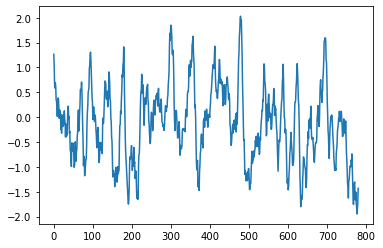

In [10]:
TPI_NOAA_raw = np.zeros(len(a))
for f in range(len(a)):
    TPI_NOAA_raw[f] = a[f]
plt.plot(TPI_NOAA_raw)

CPU times: user 19 ms, sys: 5.22 ms, total: 24.2 ms
Wall time: 21.2 ms


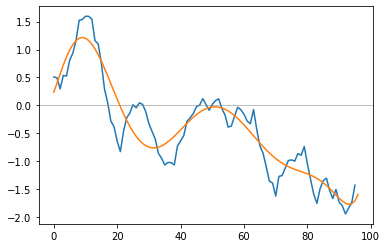

In [11]:
%%time
# fitting a polynomial for the NOAA time series from 2012-2022

length = 96
time = np.linspace(0,length,length)
TPI_NOAA_short = TPI_NOAA_raw[-length:] 
plt.plot(TPI_NOAA_short[-length:]) # 2013-03-15 to 2022-12-15
plt.axhline(0, c='grey', linewidth=.5) # last nine years: 2013 to 2022

z1 = np.polyfit(time, TPI_NOAA_short, 8) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))

### Plotting routine IPO tripole index

CPU times: user 22.5 s, sys: 1.85 s, total: 24.3 s
Wall time: 28 s


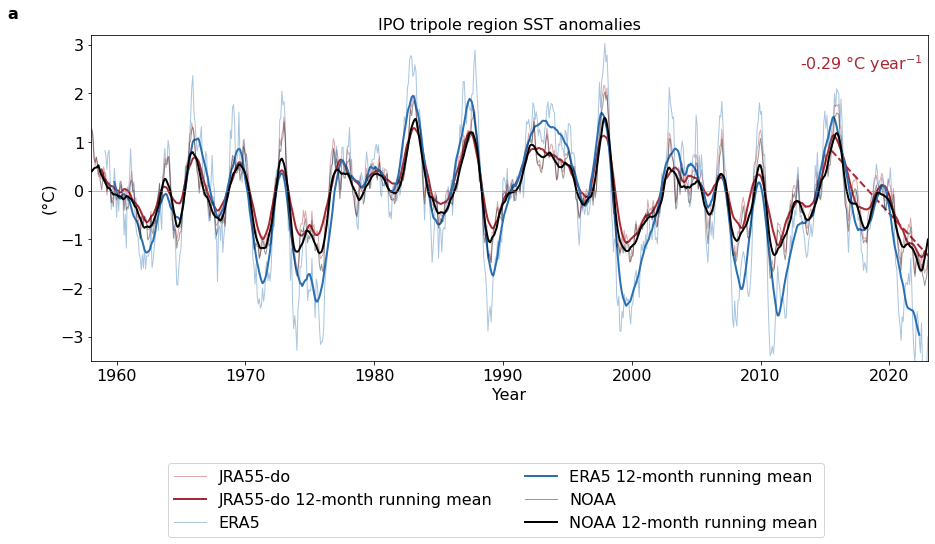

In [12]:
%%time
# -------------------------------------------------------------------------------- #
trend_period = 8 # [years] specify over which period to calculate the linear trend #
# -------------------------------------------------------------------------------- #

fig = plt.figure(figsize=(15,6))
time = np.linspace(1958.08,2023.41,785)
ax1 = plt.subplot(1,1,1)
# time series using JRA55-do ----------------------------------------------------------------------------------------------------------------- #
plt.plot(time, TPI_JRA55_raw, label='JRA55-do', c=rotblau[3], alpha=.4, linewidth=1)
plt.plot(time, TPI_JRA55_raw.rolling(time=18, center=True).mean(), label='JRA55-do 12-month running mean', c=rotblau[3], linewidth=2)

# calculate the linear trend over the last 8 years
z1 = np.polyfit(time[-(trend_period*12):], TPI_JRA55_raw[-(trend_period*12):], 1) # calculate first (linear) polynomial fit in units of [years]
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time[-(trend_period*12):],p1(time[-(trend_period*12):]), c = rotblau[3], linewidth=2, linestyle = '--') # plot trend line
plt.text(time[-125], 2.5, str(np.round(p1[1], 2)) + ' °C year$^{-1}$', fontsize=16, c = rotblau[3]) # add trend value as text

# time series using ERA5 data instead ---------------------------------------------------------------------------------------------------------- #
time2 = np.linspace(1959.08,2023,768)
plt.plot(time2, TPI_ERA5_raw, label='ERA5', c=rotblau[17], alpha=.4, linewidth=1)
plt.plot(time2, TPI_ERA5_raw.rolling(time=18, center=True).mean(), label='ERA5 12-month running mean', c=rotblau[17], linewidth=2)

# time series using NOAA data instead ---------------------------------------------------------------------------------------------------------- #
time3 = np.linspace(1958.08,2023,780)
plt.plot(time3, TPI_NOAA_raw, label='NOAA', c='k', alpha=.4, linewidth=1)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w # mode = 'same' to retain original array length
plt.plot(time3, moving_average(TPI_NOAA_raw, 12), label='NOAA 12-month running mean', c='k', linewidth=2)

plt.title('IPO tripole region SST anomalies', fontsize=16); plt.axhline(0, c='grey', linewidth=.5)
ax1.text(-.1, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold panel index letter at the top
plt.xticks(fontsize=16); plt.yticks(fontsize=16) # fontsize of ticks
plt.xlabel('Year', fontsize=16); plt.ylabel('(°C)', fontsize=16) # ticklabels
plt.xlim(1958, 2023) # center on axis with data
plt.ylim(-3.5,3.2)

handles, labels = ax1.get_legend_handles_labels() # adding a legend outside the plot
fig.legend(handles, labels, fontsize=16, ncol=2, bbox_to_anchor=(.5, -.3), loc='lower center')

# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_index_from_JRA55-do_1958-2018', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

CPU times: user 27.6 ms, sys: 714 µs, total: 28.3 ms
Wall time: 26.3 ms


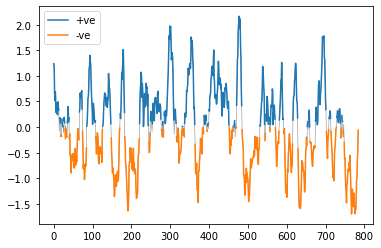

In [13]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
IPO_positive = TPI_JRA55_raw.where(TPI_JRA55_raw > 0, np.nan) # replace all zeroes by nan
IPO_negative = TPI_JRA55_raw.where(TPI_JRA55_raw < 0, np.nan) 
plt.plot(TPI_JRA55_raw, c='grey', linewidth=.5); plt.plot(IPO_positive, label='+ve'); plt.plot(IPO_negative, label='-ve'); plt.legend()

#### define the input for the figure                              ####
# -- state here which time series to use for the spatial patterns -- #
# only use time series until December 2022 as Andrew noted the last extension bit is of low quality
time_series = TPI_JRA55_raw[0:780]; suffix = 'full_ts'; filename_extension = ' for the full time series'                  #
# time_series = IPO_positive[0:780]; suffix = 'positive_ts'; filename_extension = ' when time series is positive'         #
# time_series = -IPO_negative[0:780]; suffix = 'negative_ts'; filename_extension = ' when time series is negative'         # NOTE: negative sign here for the time series, so that the spatial patterns show the La Nina-like Amundsen Sea Low deepening anomalies as in Fig. S7 of the ENSO-Antarctica GRL manuscript (Huguenin et al., 2023)
# ------------------------------------------------------------------ # 

### Standardise the time series

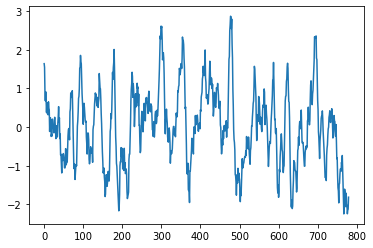

In [33]:
TPI_JRA55_std = TPI_JRA55_raw[0:780] / (TPI_JRA55_raw[0:780].std())
plt.plot(TPI_JRA55_std)

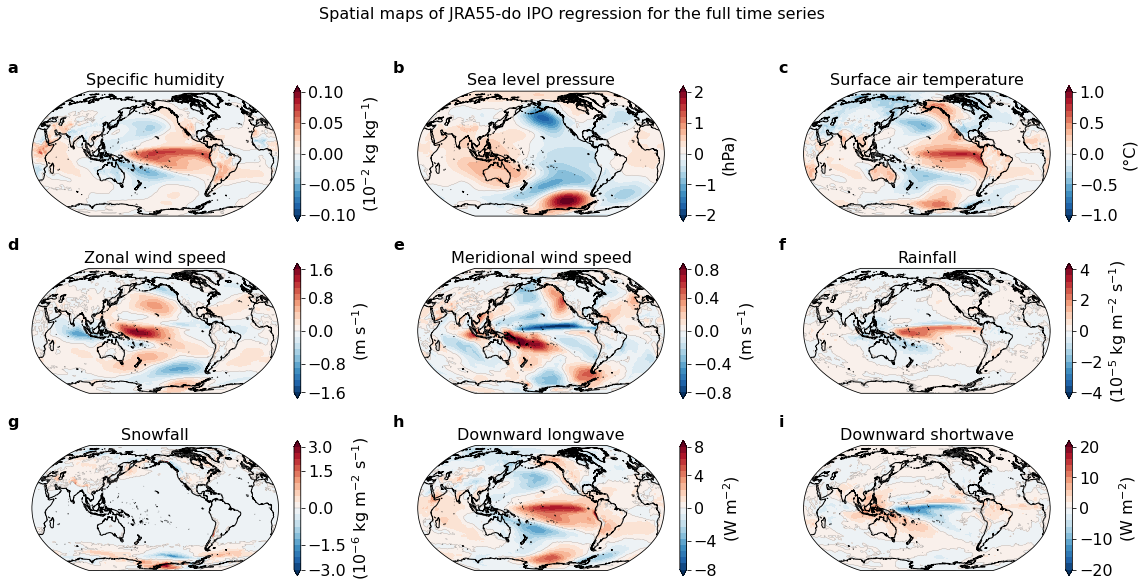

In [14]:
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

# (16,9)
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

for v in range(9): # loop through all variables
    # load in the data
    if v <= 8: 
        field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
        field = field[:780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss

        ### Regressing the time series onto the spatial SLP anomalies ----------------------------------------------------------- #
        field['time'] = time_series.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align  #
        field = ((field * time_series) / np.std(time_series)).mean(['time']) # do regression                                      #
        # ----------------------------------------------------------------------------------------------------------------------- #
    
    # IPO-scale colour bars
    if v == 0: scale = 1e2;  ticks = np.linspace(-.1,.1,21)   # huss
    if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)   # psl -> convert to hPa
    if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
    if v == 3: scale = 1;    ticks = np.linspace(-1.5,1.5,21)     # uas
    if v == 4: scale = 1;    ticks = np.linspace(-.75,.75,21) # vas
    if v == 5: scale = 1e5;  ticks = np.linspace(-4,4,21)     # prrn 
    if v == 6: scale = 1e6;  ticks = np.linspace(-2.5,2.5,21)     # prsn
    if v == 7: scale = 1;    ticks = np.linspace(-7.5,7.5,21)   # rlds
    if v == 8: scale = 1;    ticks = np.linspace(-20,20,21)   # rsds
    # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   

    # # ENSO-scale colour bars which are twice as big
    # if v == 0: scale = 1e2;  ticks = np.linspace(-.2,.2,21)   # huss
    # if v == 1: scale = 1e-2; ticks = np.linspace(-4,4,21)   # psl -> convert to hPa
    # if v == 2: scale = 1;    ticks = np.linspace(-2,2,21)     # tas
    # if v == 3: scale = 1;    ticks = np.linspace(-3,3,21)     # uas
    # if v == 4: scale = 1;    ticks = np.linspace(-1.6, 1.6,21) # vas
    # if v == 5: scale = 1e5;  ticks = np.linspace(-8,8,21)     # prrn 
    # if v == 6: scale = 1e6;  ticks = np.linspace(-5,5,21)     # prsn
    # if v == 7: scale = 1;    ticks = np.linspace(-16,16,21)   # rlds
    # if v == 8: scale = 1;    ticks = np.linspace(-40,40,21)   # rsds
    
    ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    # ------------------------------------ #
    p1  = (field*scale).plot.contourf(ax=ax1, levels = ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
    cb.set_label(label='('+var_units[v]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(var_titles[v], fontsize=16)
    fancy_plot(ax1)
    ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial maps of JRA55-do IPO regression' + filename_extension, fontsize=16)
    
    if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
    if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
   
    # # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    # plt.savefig(save + 'IPO_regression_fields_Robinson_JRA55-do-1-5-0_' + suffix, 
    #             dpi=300, facecolor='w',                                          #
    #             edgecolor='w', orientation='landscape',                          #
    #             format=None, transparent=False, bbox_inches='tight',             #
    #             pad_inches=0.1, metadata=None)                                   #
    # # --- end of script -------------------------------------------------------- # 
# Wall time: 2min 2s

### Saving the spatial patterns as .nc files

In [49]:
%%time

# first delete the files if they already exist as otherwise the script runs into problems --- #
# os.system('rm -r /g/data/e14/mv7494/IPOAnt_input/time_series/*')
# os.system('rm -r /g/data/e14/mv7494/IPOAnt_input/spatial_patterns/*')
# ------------------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2550 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

JRAout = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/' # Output location for storing scaling files created by this script
var  = ['q_10',     'slp', 't_10',    'u_10',    'v_10',    'rain', 'snow', 'rlds', 'rsds', 'runoff_all'] # input variables for ACCESS-OM2
var2 = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for JRA55-do-1-3
var3 = ['huss',     'psl', 'tas',     'uas',     'vas',     'prra', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for monthly JRA55-do-1-3 files

for n in [1]: # loop through the different simulations
    if n == 0:
        suffix = 'IPO_time_series_2015-2022'; tend = 2557 # end year of window in which scaling will be applied
        TPI_short = TPI_JRA55_raw[-(trend_period*12):] # the IPO TPI over the 2015-2022 period [°C]
        ts = TPI_JRA55_raw / np.std(TPI_JRA55_raw)    # normalise the time series             [°C/°C = unitless]
    if n == 1:
        suffix = 'IPO_time_series_1958-2022'; tend = 2614
    
    print('Creating forcing combining RYF & linear atmospheric trends over ' + suffix[16:])
    print('-------------------------------------------------------------------------')

    for i in range(len(var)): # loop through all variables except taux and tauy
        # get the JRA55-do for the file structure
        if var[i] in ['q_10','slp','t_10','u_10','v_10']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; length_year = 2920;
        if var[i] in ['rain','snow','rlds','rsds']:       domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
        if var[i] in ['runoff_all']:                      domain = 'land/day/';    timestep = ['0101','1231'];         length_year = 365;
        print(domain+var[i])
        
        JRA_field = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc') 
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Creating time series files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        # Extract time series and structure from original files:
        timeRYF = JRA_field[var2[i]].time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate the time series to correct temporal resolution of input file
        if n == 0:      # np.interp(              target length           ,            original length              , original data)
            ts_interp = np.interp(np.linspace(1,24,len((timeYR-zeroYR))), np.linspace(0,len(ts),len(ts)), ts)

        # Create new Datasets:
        ds = xr.DataArray(ts_interp, dims=['time'], coords={'time': timeFULL}, attrs=JRA_field[var2[i]].attrs)
        DS_out = JRA_field.drop_vars(var2[i]).assign_coords({'time':timeFULL}) 
        DS_out[var2[i]] = ds
        DS_out.attrs.update({'title': 'Scaling for ' + DS_out.attrs['title']})
        DS_out.time.attrs.update(JRA_field.time.attrs) # get the right attribute from the JRA file
        DS_out.time.encoding['units'] = "days since '1900-01-01'" 
        if i == 0: ts_huss_10m = DS_out.huss_10m
        if i == 1: ts_psl      = DS_out.psl
        if i == 2: ts_tas_10m  = DS_out.tas_10m
        if i == 3: ts_uas_10m  = DS_out.uas_10m
        if i == 4: ts_vas_10m  = DS_out.vas_10m
        if i == 5: ts_prrn     = DS_out.prrn
        if i == 6: ts_prsn     = DS_out.prsn
        if i == 7: ts_rlds     = DS_out.rlds
        if i == 8: ts_rsds     = DS_out.rsds
        if i == 9: ts_friver   = DS_out.friver
        
        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Create spatial scaling files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        DS_out = JRA_field.isel(time=0)
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var3[i]+'_monthly_anom_1958-2023.nc')[var3[i]]
        anom = anom.rename({'lon': 'longitude','lat': 'latitude'}).load()

        # regress the IPO tripole index onto the anomaly field to get the regression pattern
        anom['time'] = TPI_JRA55_raw.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align

        DS_out[var2[i]] = ((anom * TPI_JRA55_raw) / np.std(TPI_JRA55_raw)).mean(['time']) # do regression
        DS_out['time'] = anom.time[0]
        # index['time'] = field.time # replace N34 time step values with the values from the field       

        if i == 0: huss_10m = DS_out.huss_10m#.drop(['height','huss_10m'])
        if i == 1: psl      = DS_out.psl
        if i == 2: tas_10m  = DS_out.tas_10m#.drop(['height','tas_10m'])
        if i == 3: uas_10m  = DS_out.uas_10m#.drop(['height','uas_10m'])
        if i == 4: vas_10m  = DS_out.vas_10m#.drop(['height','vas_10m'])
        if i == 5: prrn     = DS_out.prrn#.drop(['prrn'])
        if i == 6: prsn     = DS_out.prsn#.drop(['prsn'])
        if i == 7: rlds     = DS_out.rlds#.drop(['rlds'])
        if i == 8: rsds     = DS_out.rsds#.drop(['rsds'])
        if i == 9: friver   = DS_out.friver#.drop(['friver'])

   # saving the time series back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': ts_huss_10m, 'psl': ts_psl, 'tas_10m': ts_tas_10m,
                      'uas_10m': ts_uas_10m, 'vas_10m': ts_vas_10m,
                      'prrn': ts_prrn, 'prsn': ts_prsn,
                      'rlds': ts_rlds, 'rsds': ts_rsds})
    DS4.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/time_series/ts_'+suffix+'.nc')  

    # separate file for friver as it has a resolution of (730)
    ts_friver.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/time_series//ts_'+suffix+'_friver.nc')  
    
    # saving the spatial patterns back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': huss_10m, 'psl': psl, 'tas_10m': tas_10m,
                      'uas_10m': uas_10m, 'vas_10m': vas_10m,
                      'prrn': prrn, 'prsn': prsn,
                      'rlds':rlds, 'rsds': rsds})

    DS4.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/spatial_patterns/sp_'+suffix+'.nc')  
    friver.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/spatial_patterns/sp_'+suffix+'_friver.nc')  
        
    print('----------------------------------------------------------')
# Wall time: 43.3 s       per variable 
# Wall time: 16min 30s for all variables

Creating forcing combining RYF & linear atmospheric trends over 1958-2022
-------------------------------------------------------------------------
atmos/3hrPt/q_10


ValueError: conflicting sizes for dimension 'time': length 2920 on the data but length 189800 on coordinate 'time'